In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
X = torch.randn(4,5)

4个样本 每个样本都是5个特征

In [7]:
X

tensor([[ 1.7966,  1.1930, -0.7099, -0.3479, -1.1418],
        [ 0.4967, -1.4583, -0.1602, -1.6547,  0.0456],
        [ 0.4694, -1.2293,  0.8237,  0.5772, -1.4365],
        [-1.0842,  0.5436, -1.3122,  1.0892,  0.8553]])

In [3]:
Y = torch.randn(4,2)
# 每个样本两个特征
print(Y)

tensor([[-0.0371,  0.4415],
        [ 0.2429, -0.9214],
        [ 0.5022,  0.0518],
        [ 0.7070, -1.2248]])


构建模型
该模型输入是5维向量
输出10维向量
使用线性层+激活函数＋线性层 实现



In [4]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(5,10)
        self.linear2 = nn.Linear(10,2)
    
    def forward(self,x):
        out_1 = self.linear1(x)
        out_2 = F.relu(out_1)
        out_3 = self.linear2(out_2)
        return out_3

In [6]:
model = SimpleNet()

model.parameters() 是一个生成器（iterator），它返回模型中所有 参数

一定要把输入输出搞清楚，别搞混

linear(5,10)的意思不是说，要你输入一个(5,10)形状的tensor，而是说输入一个5维的tensor，所以这个向量是(3,5),(4,5)(1,2,4,5)都无所谓，只要最后一个数是5，即5个特征即可。

输出是10维的tensor。  
总的来说，输入（batch，5），输出（batch，10）

那么里面的权重长啥样？

一个经典的公式

$$ output=input⋅weight^T+bias $$

input是（batch，5）

那权重的专置就是（5，10）

那weight就是（10，5）

咦，那为什么不直接将weight设为（5，10）呢

当然可以，tensorflow框架就是这么干的，我们pytorch选择
[out_features, in_features]的形式，
有个好处，

一共10个输出神经元
就是第i行为第i个输出神经元的权重


In [15]:
print(list(model.parameters()))

[Parameter containing:
tensor([[ 0.3245,  0.0128,  0.3166, -0.2784, -0.3144],
        [-0.0809,  0.2010, -0.3917, -0.3973,  0.1925],
        [ 0.4091, -0.1493, -0.2874, -0.3728,  0.4152],
        [ 0.2080,  0.2353, -0.2766,  0.3726, -0.2846],
        [-0.2944,  0.1768, -0.2505, -0.4450,  0.0229],
        [ 0.0846, -0.1356,  0.0597,  0.1093, -0.0244],
        [-0.3801,  0.2351, -0.3752, -0.0908,  0.2574],
        [ 0.2458, -0.1102,  0.0438,  0.1022,  0.3519],
        [-0.1163, -0.0774,  0.0151,  0.1418,  0.4438],
        [ 0.2660, -0.0664,  0.1581,  0.1654,  0.1135]], requires_grad=True), Parameter containing:
tensor([-0.2486,  0.1016,  0.1948,  0.0307, -0.1925, -0.0721, -0.2754,  0.3172,
         0.3310, -0.2632], requires_grad=True), Parameter containing:
tensor([[ 0.2031,  0.0994,  0.0452, -0.2744, -0.0027, -0.2556,  0.1908, -0.2535,
         -0.0672,  0.0913],
        [-0.2372, -0.3128,  0.1345, -0.1422,  0.1206, -0.0141,  0.2888,  0.1766,
         -0.2446, -0.1081]], requires_grad=

In [7]:
model

SimpleNet(
  (linear1): Linear(in_features=5, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)

In [10]:
model(X)

tensor([[ 0.1304, -0.1617],
        [ 0.3786, -0.2186],
        [-0.0996, -0.1704],
        [ 0.4627, -0.2185]], grad_fn=<AddmmBackward0>)

# 定义优化器

有哪些参数需要更新呢？


In [13]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

linear1.weight
linear1.bias
linear2.weight
linear2.bias


In [16]:
optimizer = optim.AdamW(model.parameters(),lr=0.01)

# 开始训练

In [17]:
Y_pred = model(X)

In [18]:
Y_pred

tensor([[ 0.1304, -0.1617],
        [ 0.3786, -0.2186],
        [-0.0996, -0.1704],
        [ 0.4627, -0.2185]], grad_fn=<AddmmBackward0>)

In [20]:
loss_fn = nn.MSELoss()
loss = loss_fn(Y_pred,Y)
loss

tensor(0.2985, grad_fn=<MseLossBackward0>)

In [21]:
loss.backward()

In [22]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}.grad: mean={param.grad.mean().item():.4f}, std={param.grad.std().item():.4f}")

linear1.weight.grad: mean=0.0099, std=0.0660
linear1.bias.grad: mean=0.0019, std=0.0398
linear2.weight.grad: mean=0.0244, std=0.1749
linear2.bias.grad: mean=0.0426, std=0.2522


In [23]:
optimizer.step()

初始化时，我们希望权重的 mean ≈ 0，
std 在合适范围（如 Xavier/He 初始化）
训练中，如果 mean 疯狂增长 → 可能发散
如果 mean 一直不动 → 可能没学到东西
📌 所以 mean 是一个“健康指标”，帮助你判断参数是否在合理范围内变化。 

In [24]:
print("\n=== optimizer.step() 后（参数已更新）===")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: mean={param.data.mean().item():.4f}, std={param.data.std().item():.4f}")



=== optimizer.step() 后（参数已更新）===
linear1.weight: mean=0.0090, std=0.2535
linear1.bias: mean=-0.0107, std=0.2392
linear2.weight: mean=-0.0271, std=0.1905
linear2.bias: mean=0.0930, std=0.2945


In [25]:
optimizer.zero_grad()

一次训练就结束了

那我们进行多次训练
模型训练后 权重就无法改变了。  

所以说 如果你重复运行这个训练代码 loss会越来越低 每次都比上次运行低

Step 0: grad_mean=-0.000005, grad_std=0.000057
Step 1: grad_mean=-0.000004, grad_std=0.000059
Step 2: grad_mean=-0.000002, grad_std=0.000060
Step 3: grad_mean=0.000000, grad_std=0.000061
Step 4: grad_mean=0.000001, grad_std=0.000058
Step 5: grad_mean=-0.000000, grad_std=0.000051
Step 6: grad_mean=-0.000003, grad_std=0.000042
Step 7: grad_mean=-0.000007, grad_std=0.000037
Step 8: grad_mean=-0.000010, grad_std=0.000040
Step 9: grad_mean=-0.000012, grad_std=0.000045
Step 10: grad_mean=-0.000012, grad_std=0.000048
Step 11: grad_mean=-0.000010, grad_std=0.000046
Step 12: grad_mean=-0.000007, grad_std=0.000043
Step 13: grad_mean=-0.000004, grad_std=0.000039
Step 14: grad_mean=-0.000002, grad_std=0.000037
Step 15: grad_mean=-0.000002, grad_std=0.000034
Step 16: grad_mean=-0.000003, grad_std=0.000030
Step 17: grad_mean=-0.000005, grad_std=0.000027
Step 18: grad_mean=-0.000007, grad_std=0.000028
Step 19: grad_mean=-0.000008, grad_std=0.000031


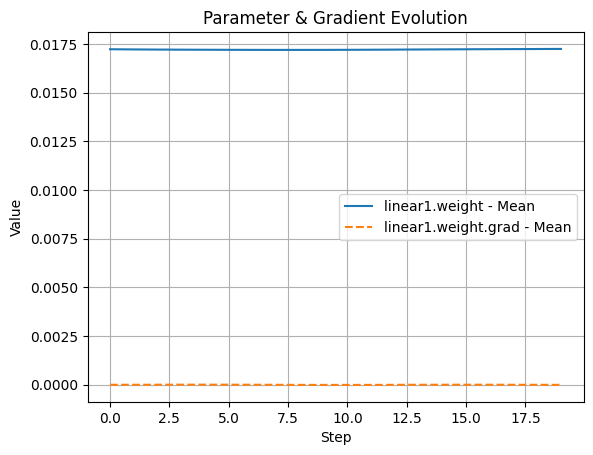

In [35]:
import matplotlib.pyplot as plt

# 存储历史
weight_means = []
grad_means = []

for step in range(20):
    # 前向
    y_pred = model(X)
    loss = nn.MSELoss()(y_pred, Y)

    # 反向
    optimizer.zero_grad()  # 清零（
    loss.backward()

    # 打印 linear1 的梯度大小
    grad_mean = model.linear1.weight.grad.mean().item()
    grad_std = model.linear1.weight.grad.std().item()
    print(f"Step {step}: grad_mean={grad_mean:.6f}, grad_std={grad_std:.6f}")

    weight_mean = model.linear1.weight.data.mean().item()
    grad_mean = model.linear1.weight.grad.data.mean().item()

    weight_means.append(weight_mean)
    grad_means.append(grad_mean)

    # 更新
    optimizer.step()

# 画图
plt.plot(weight_means, label="linear1.weight - Mean")
plt.plot(grad_means, label="linear1.weight.grad - Mean", linestyle='--')
plt.xlabel("Step")
plt.ylabel("Value")
plt.title("Parameter & Gradient Evolution")
plt.legend()
plt.grid(True)
plt.show()